In [1]:
import numpy as np
import scipy
from scipy.linalg import lu_factor, lu_solve
from scipy.linalg import qr, solve_triangular
import matplotlib as mpl
import matplotlib.pyplot as plt
import bspy

# ODE \#3

### $$y'(t)=\begin{pmatrix}0 & -\pi\cr \pi & 0\cr\end{pmatrix}y(t),\qquad y(0)=\begin{pmatrix}1\cr 0\cr\end{pmatrix}$$

knots: [0.  0.  0.  0.  0.2 0.4 0.6 0.8 1.  1.  1.  1. ]
t: 0.0 ix: 4 [-15.  15.   0.   0.] [1. 0. 0. 0.]
t: 0.16666666666666666 ix: 4 [-0.41666667 -4.27083333  2.95138889  1.73611111] [0.00462963 0.38773148 0.51118827 0.09645062]
t: 0.3333333333333333 ix: 5 [-0.41666667 -3.19444444  2.5         1.11111111] [0.00925926 0.36728395 0.57407407 0.04938272]
t: 0.5 ix: 6 [-0.625 -3.125  3.125  0.625] [0.02083333 0.47916667 0.47916667 0.02083333]
t: 0.6666666666666666 ix: 7 [-1.11111111 -2.5         3.19444444  0.41666667] [0.04938272 0.57407407 0.36728395 0.00925926]
t: 0.8333333333333333 ix: 8 [-1.73611111 -2.95138889  4.27083333  0.41666667] [0.09645062 0.51118827 0.38773148 0.00462963]
t: 1.0 ix: 8 [  0.   0. -15.  15.] [0. 0. 0. 1.]


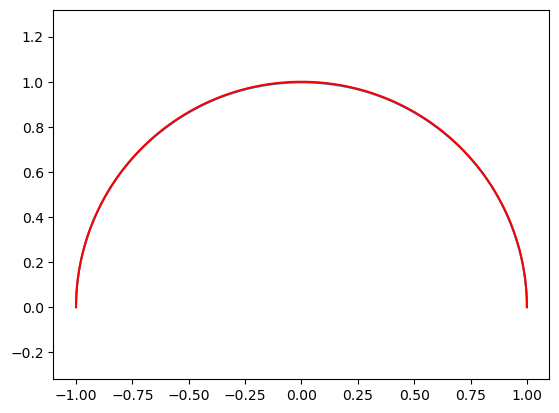

In [87]:
#y1'(t) = -piy2(t)
#y2'(t) = piy1(t)

#set parameters
degree = 3
nknots = 4 #interior knots

#create knot vector
knots = np.linspace(0.0, 1.0, nknots + 2)
knots = np.array(degree * [knots[0]] + list(knots) + degree * [knots[-1]]) #add extra knots at beginning and end
print("knots:", knots)


#initialize order and dimension
order = degree + 1
n = len(knots) - order #dimension
#print("dimensions:", n)

collocationpoints = np.linspace(0.0, 1.0, n - 1)
#print("collocation points:", collocationpoints)

#initialize collocation matrix
collocation = np.zeros((2 * n, 2 * n))

#find index of first knot in the array that follows point of evaluation, set Bslipne boundary condition to 0.0 
ix = np.searchsorted(knots, 0.0, side = 'right')
ix = min(ix, n)

#fill collocation matrix with Bspline values at 0.0
bvalues = bspy.Spline.bspline_values(ix, knots, order, 0.0)
collocation[0, 2 * (ix - order) : 2 * ix : 2] = bvalues
collocation[1, 2 * (ix - order) + 1: 2 * ix + 1: 2] = bvalues
#print("initiallized collocation:", collocation)

for irow, t in enumerate(collocationpoints):
    ix = np.searchsorted(knots, t, side = 'right')
    ix = min(ix, n)
    
    #calculate Bspline and derivative at t
    bvalues = bspy.Spline.bspline_values(ix, knots, order, t)
    bvaluesp = bspy.Spline.bspline_values(ix, knots, order, t, 1)
    print("t:", t, "ix:", ix, bvaluesp, bvalues)
    
    #from the irow value after boundary condition (irow) insert y' - y
    collocation[2 * irow + 2, 2 * (ix - order):2 * ix:2] = - np.pi * bvalues # Starting from the first index, alpha
    collocation[2 * irow + 2, 2 * (ix - order) + 1:2 * ix + 1:2] = bvaluesp  # beta
    collocation[2 * irow + 3, 2 * (ix - order) :2 * ix:2] = bvaluesp # alpha
    collocation[2 * irow + 3, 2 * (ix - order) + 1:2 * ix + 1:2] = np.pi * bvalues # beta
    
# Create the right hand side
rhs = np.zeros((2 * n,))
rhs[0] = 1.0
rhs[1] = 0.0
#print("rhs:", rhs)
#print("c: ", collocation)

# Solve the linear system
lupiv = scipy.linalg.lu_factor(collocation)
alpha = scipy.linalg.lu_solve(lupiv, rhs)


alpha_u = alpha[0::2]  
alpha_v = alpha[1::2]

#create spline function
u = bspy.Spline(1, 1, [order], [n], [knots], [alpha_u])
v = bspy.Spline(1, 1, [order], [n], [knots], [alpha_v])
u(0.0), u(0.5), u(1.0)
v_values = [v(0.0), v(0.5), v(1.0)]

#plot
#plt.plot(*u.graph()(np.linspace(0.0,1.0,101)))
tvals = np.linspace(0, 1, 100)
y1_val = u(tvals)
y2_val = v(tvals)
plt.plot(y1_val, y2_val)

tvals = np.linspace(0, 1, 100)
y1 = np.cos(np.pi * tvals)
y2 = np.sin(np.pi * tvals)
plt.plot(y1, y2, 'r')
plt.axis('equal')
plt.show()